In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml.analysis_utils import train_test_generator
from hipe4ml import plot_utils
from enum import Enum
import gc, os
import plotly
import itertools

In [2]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/mgr/'
fileName = directory + 'trees/PlainTree200k_trdrich_12agev.root'
# fileName = directory + 'PlainTree10K_ml_DCM_12gev.root'
fileNameTest = directory + 'trees/PlainTree200k_trdrich_12agev.root'
directory= directory + 'jupyter/'
# fileNameTest = directory + 'PlainTree10k_ml_DCM_12gev.root'

In [3]:
#preselection cuts
mass2Cut = """ -1. < Complex_mass2 < 2."""
pTCut = """ Complex_pT < 2."""
qCut = """ Complex_q > 0 """
antiParticles : bool = False
pCut = """ 0 < Complex_p <2 """ 

In [4]:
#data import with preselections
def loadFile(fileName: str) -> TreeHandler:
    return (TreeHandler(fileName,'plain_tree')
.get_subset(mass2Cut)
.get_subset(pTCut)
.get_subset(qCut)
.get_subset(pCut))

particles = loadFile(fileName)

In [5]:
particles.get_data_frame().head(10)

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1              5.839708             5.313001                  0.520030   
2              4.722127             4.181828                  0.456715   
7              5.390869             5.038420                  0.541778   
10             5.481655             5.204248                  0.389541   
12             5.282866             4.732232                  0.292067   
13             5.424021             5.076087                  0.629069   
14             5.701984             5.217088                  1.302346   
24             4.982846             4.780129                  0.616440   
26             5.635751             5.426417                  0.471135   
27             5.155520             4.999420                  0.243999   

    Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  Complex_p  \
1           3.254713     1.615815      0.139570       0.013776   1.040541   
2           6.383036     2.477988      0.139570       0.009510   0.877198   
7           0.983985     3.756489      0.139570       0.022315   0.888626   
10         16.352009     2.234060      0.000511      -0.000921   0.460188   
12          2.799417     1.127367      0.000511      -0.004686   0.981654   
13          0.576499     2.461298      0.493677       0.238667   1.332283   
14          1.042173     1.710407      0.139570       0.000192   1.535469   
24          1.342454     1.694063      0.938272       0.979229   1.594529   
26          0.701677     3.479935      0.139570       0.022383   1.635057   
27         11.140937     2.491263      0.000511       0.000592   0.579213   

    Complex_pT  Complex_phi  ...  Complex_rapidity  Complex_trd_proba_e  \
1     0.397858     1.967648  ...          1.562429             0.003401   
2     0.146186     1.035680  ...          2.160347             0.049470   
7     0.041505    -1.281722  ...          2.507459             0.000342   
10    0.097448    -2.465459  ...          2.234046            -1.500000   
12    0.575513    -2.893483  ...          1.127367             0.096185   
13    0.225708    -0.622119  ...          1.616668             0.047699   
14    0.537629    -3.062980  ...          1.679923             0.001239   
24    0.566912    -2.059282  ...          1.114219             0.053815   
26    0.100655    -1.021812  ...          2.945500             0.017450   
27    0.095271     0.349122  ...          2.491248            -1.500000   

    Complex_trd_proba_k  Complex_trd_proba_p  Complex_trd_proba_pi  \
1              0.426412             0.173623              0.396563   
2              0.324028             0.285724              0.340778   
7              0.525351             0.069788              0.404519   
10            -1.500000            -1.500000             -1.500000   
12             0.175298             0.497897              0.230621   
13             0.269004             0.363714              0.319583   
14             0.457461             0.212057              0.329243   
24             0.248682             0.365606              0.331896   
26             0.311063             0.329330              0.342157   
27            -1.500000            -1.500000             -1.500000   

    Complex_id  Complex_n_hits_rich  Complex_nhits_trd  Complex_pid  Complex_q  
1          1.0                 29.0                4.0        211.0        1.0  
2          2.0                 27.0                2.0        211.0        1.0  
7          7.0                 26.0                4.0        211.0        1.0  
10        10.0                 35.0                4.0        -11.0        1.0  
12        12.0                 27.0                4.0        -11.0        1.0  
13         0.0                 18.0                3.0        321.0        1.0  
14         1.0                 22.0                4.0        211.0        1.0  
24        11.0                 32.0                3.0       2212.0        1.0  
26        13.0 

In [6]:
class Pid(Enum):
    POSITRON = -11.0
    ELECTRON = 11.0
    PROTON = 2212.0
    ANTI_PROTON = -2212.0 
    NEG_MUON = -13.0
    POS_MUON = 13.0
    NEG_PION = -211.0
    POS_PION = 211.0
    NEG_KAON = -321.0
    POS_KAON = 321.0
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 

def getParticlesType(th: TreeHandler, pid: float) -> TreeHandler:
    return (th.get_subset("Complex_pid == {}"
        .format(pid)))

if antiParticles == False:
    protons = getParticlesType(particles, Pid.PROTON.value)
    kaons = getParticlesType(particles, Pid.POS_KAON.value)
    pions = getParticlesType(particles, [Pid.POS_PION.value, Pid.POS_MUON.value, Pid.POSITRON.value])
    # muons = getParticlesType(particles, Pid.POS_MUON.value)
    # electrons = getParticlesType(particles, Pid.POSITRON.value)
elif antiParticles == True:
    protons = getParticlesType(particles, Pid.ANTI_PROTON.value)
    kaons = getParticlesType(particles, Pid.NEG_KAON.value)
    pions = getParticlesType(particles, [Pid.NEG_PION.value, Pid.NEG_MUON.value, Pid.ELECTRON.value])
    # muons = getParticlesType(particles, Pid.NEG_MUON.value)
    # electrons = getParticlesType(particles, Pid.ELECTRON.value)  
    
del particles
gc.collect()

2457

In [7]:
pions.get_data_frame().head(10)

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1              5.839708             5.313001                  0.520030   
2              4.722127             4.181828                  0.456715   
7              5.390869             5.038420                  0.541778   
10             5.481655             5.204248                  0.389541   
12             5.282866             4.732232                  0.292067   
14             5.701984             5.217088                  1.302346   
26             5.635751             5.426417                  0.471135   
27             5.155520             4.999420                  0.243999   
35             5.039884             4.911901                  0.424900   
38             5.281833             4.943711                  0.370743   

    Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  Complex_p  \
1           3.254713     1.615815      0.139570       0.013776   1.040541   
2           6.383036     2.477988      0.139570       0.009510   0.877198   
7           0.983985     3.756489      0.139570       0.022315   0.888626   
10         16.352009     2.234060      0.000511      -0.000921   0.460188   
12          2.799417     1.127367      0.000511      -0.004686   0.981654   
14          1.042173     1.710407      0.139570       0.000192   1.535469   
26          0.701677     3.479935      0.139570       0.022383   1.635057   
27         11.140937     2.491263      0.000511       0.000592   0.579213   
35          1.500848     1.917656      0.000511      -0.008798   1.349194   
38          0.862897     2.588326      0.000511       0.263761   1.167334   

    Complex_pT  Complex_phi  ...  Complex_rapidity  Complex_trd_proba_e  \
1     0.397858     1.967648  ...          1.562429             0.003401   
2     0.146186     1.035680  ...          2.160347             0.049470   
7     0.041505    -1.281722  ...          2.507459             0.000342   
10    0.097448    -2.465459  ...          2.234046            -1.500000   
12    0.575513    -2.893483  ...          1.127367             0.096185   
14    0.537629    -3.062980  ...          1.679923             0.001239   
26    0.100655    -1.021812  ...          2.945500             0.017450   
27    0.095271     0.349122  ...          2.491248            -1.500000   
35    0.388149    -0.534201  ...          1.917655             0.861691   
38    0.174455     2.751656  ...          2.588322             0.021639   

    Complex_trd_proba_k  Complex_trd_proba_p  Complex_trd_proba_pi  \
1              0.426412             0.173623              0.396563   
2              0.324028             0.285724              0.340778   
7              0.525351             0.069788              0.404519   
10            -1.500000            -1.500000             -1.500000   
12             0.175298             0.497897              0.230621   
14             0.457461             0.212057              0.329243   
26             0.311063             0.329330              0.342157   
27            -1.500000            -1.500000             -1.500000   
35             0.027000             0.081390              0.029919   
38             0.409893             0.196967              0.371501   

    Complex_id  Complex_n_hits_rich  Complex_nhits_trd  Complex_pid  Complex_q  
1          1.0                 29.0                4.0        211.0        1.0  
2          2.0                 27.0                2.0        211.0        1.0  
7          7.0                 26.0                4.0        211.0        1.0  
10        10.0                 35.0                4.0        -11.0        1.0  
12        12.0                 27.0                4.0        -11.0        1.0  
14         1.0                 22.0                4.0        211.0        1.0  
26        13.0                 25.0                3.0        211.0        1.0  
27        14.0                 18.0                2.0        -11.0        1.0  
35         3.0 

In [8]:
train_test_data = train_test_generator([protons, kaons, pions], [0,1,2], 
    test_size=0.1, random_state=42)

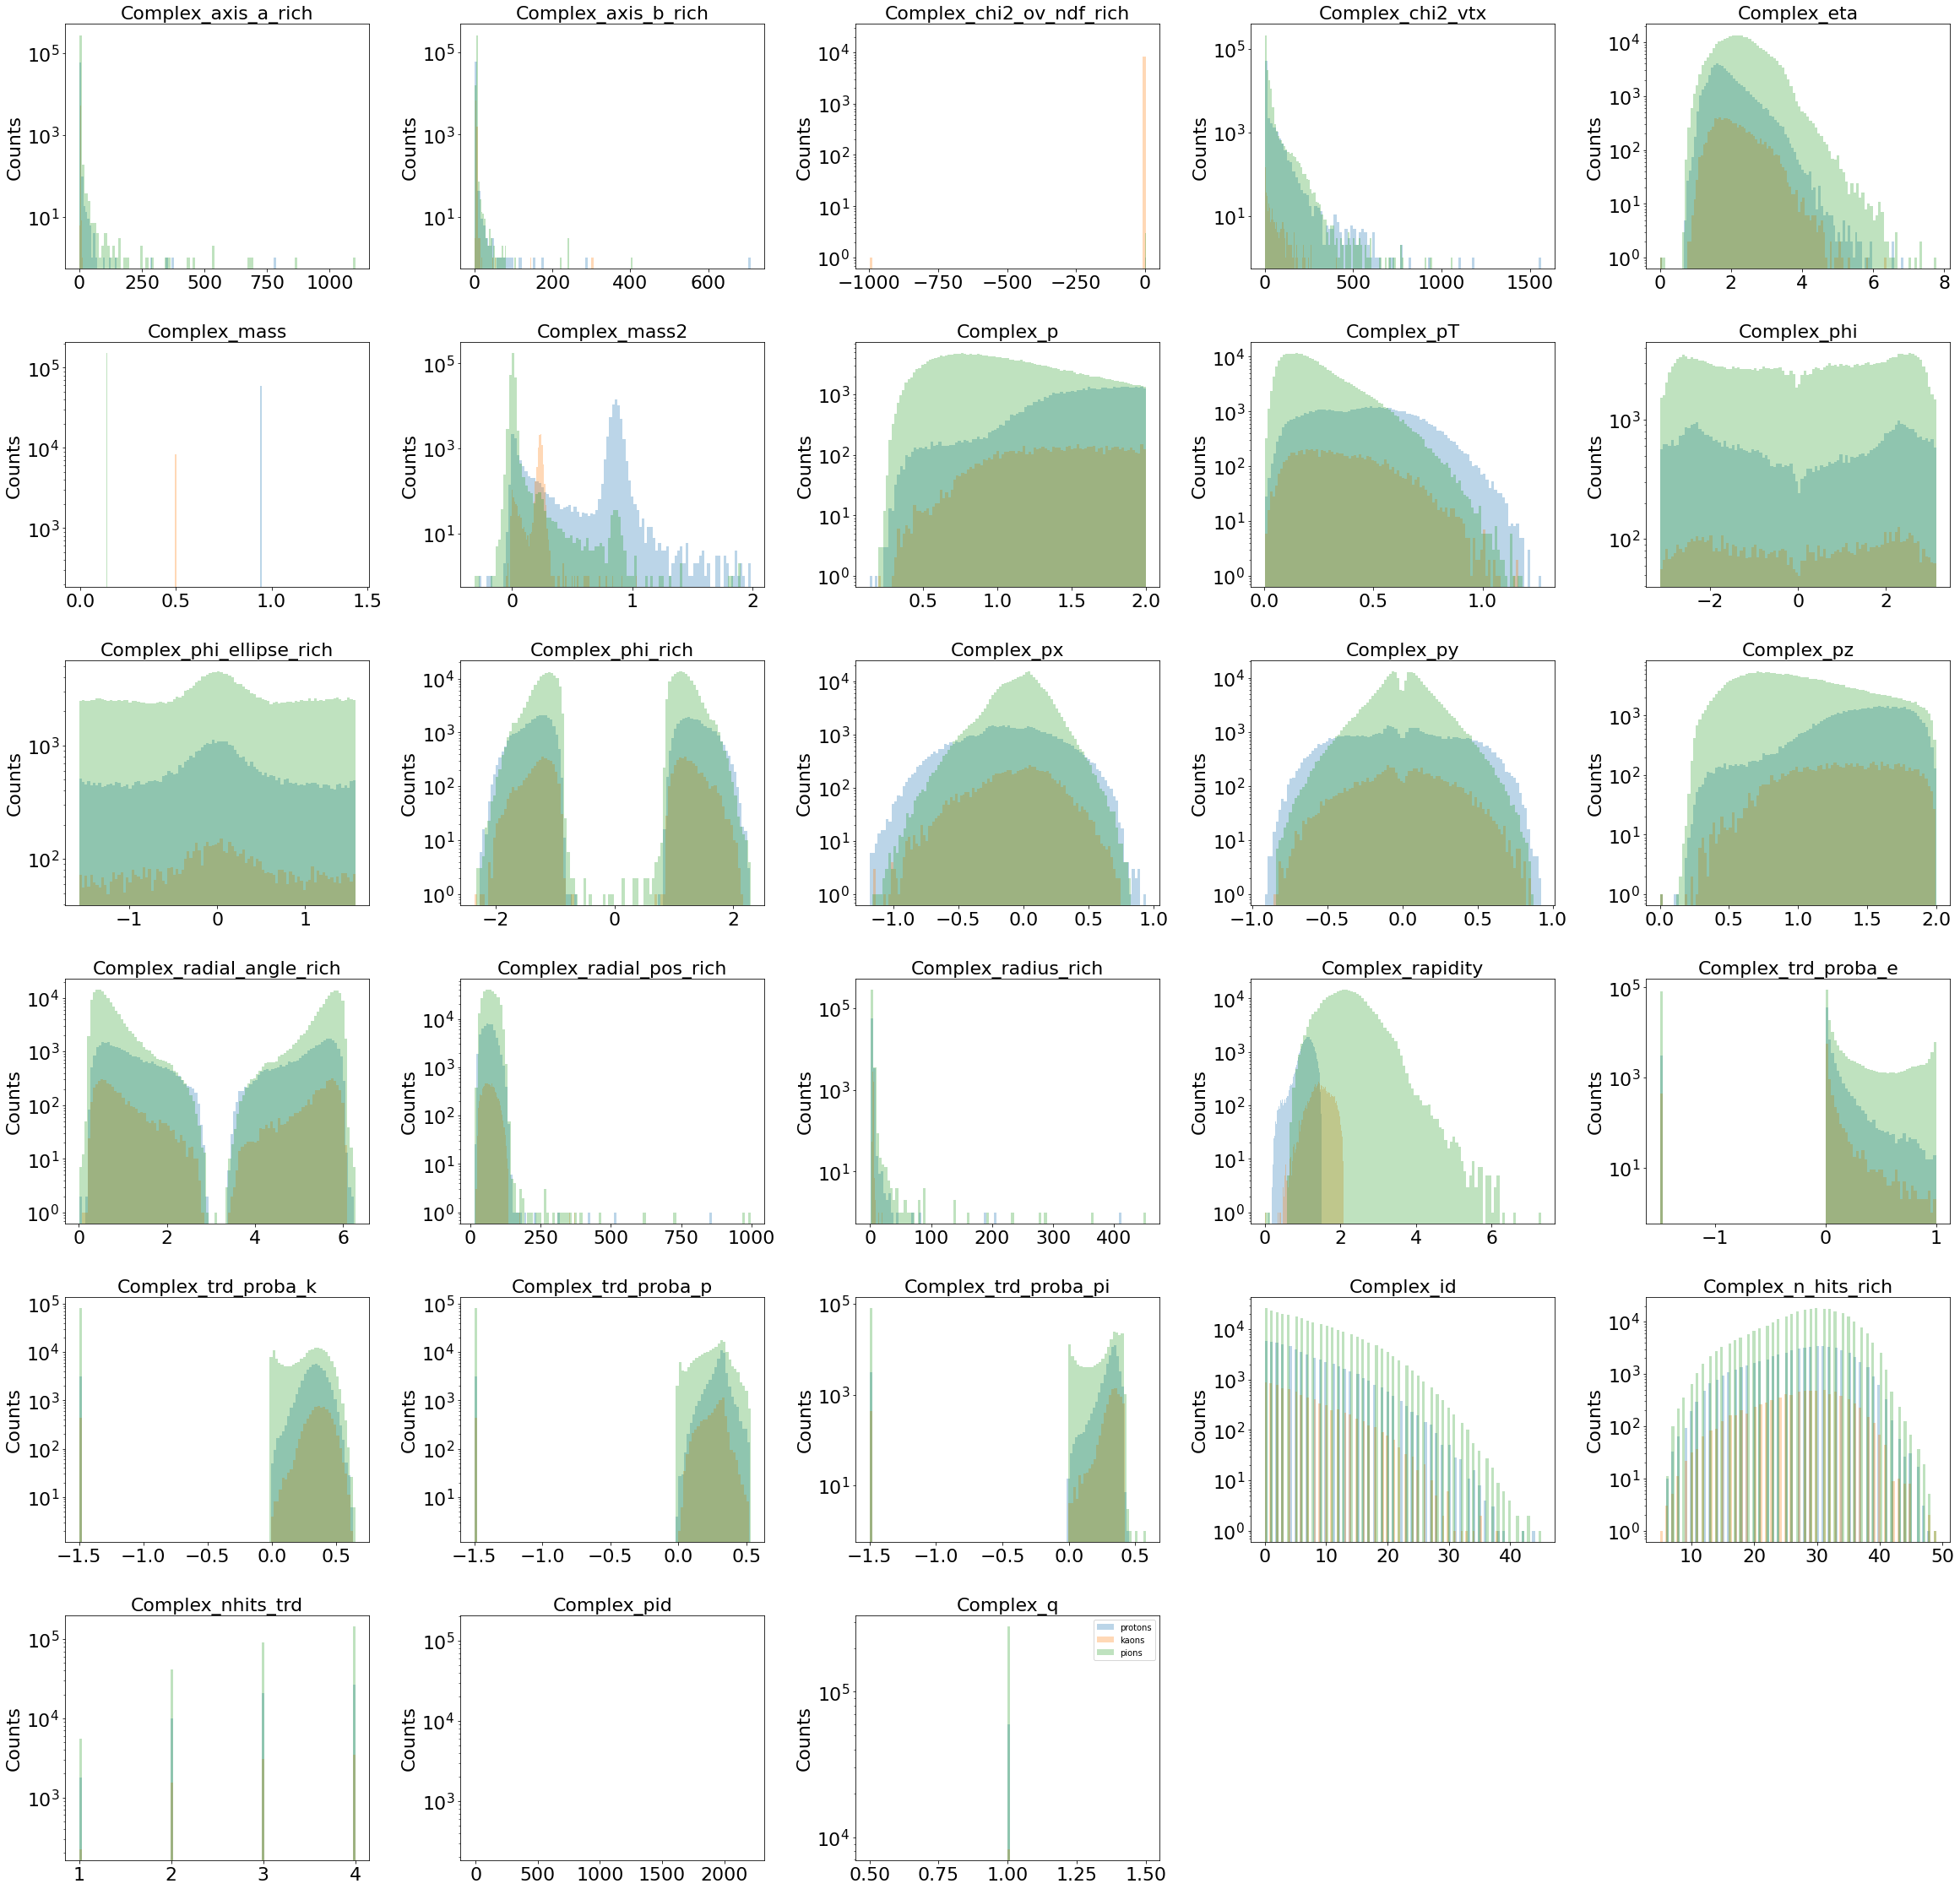

In [9]:
import matplotlib

params = {'axes.titlesize':'22','axes.labelsize':'22',
          'xtick.labelsize':'22',
          'ytick.labelsize':'22'}
matplotlib.rcParams.update(params)

vars_to_draw =  protons.get_var_names()

leg_labels = ['protons', 'kaons', 'pions']

plot_utils.plot_distr([protons, kaons, pions], vars_to_draw, bins=100, labels=leg_labels, log=True, figsize=(40, 40), alpha=0.3, grid=False)
plt.show()

<Figure size 432x288 with 0 Axes>

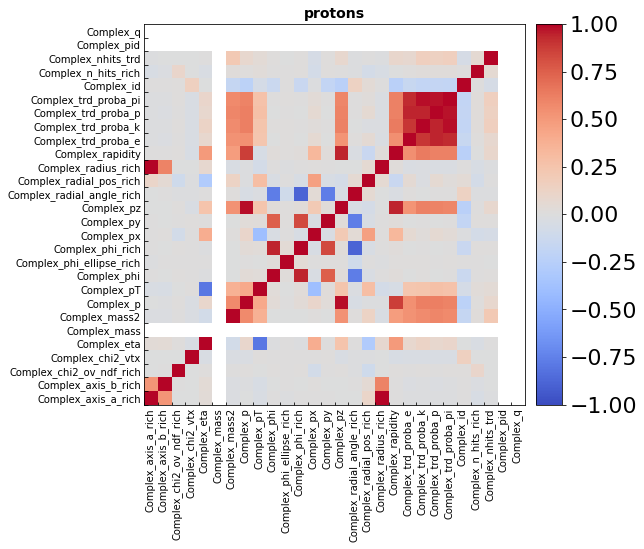

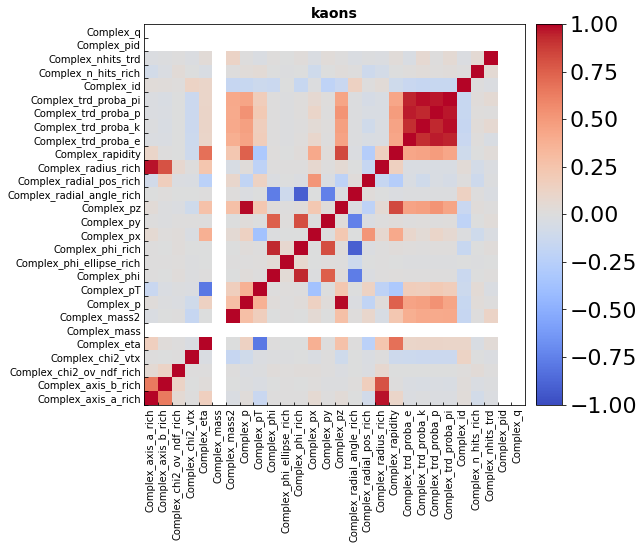

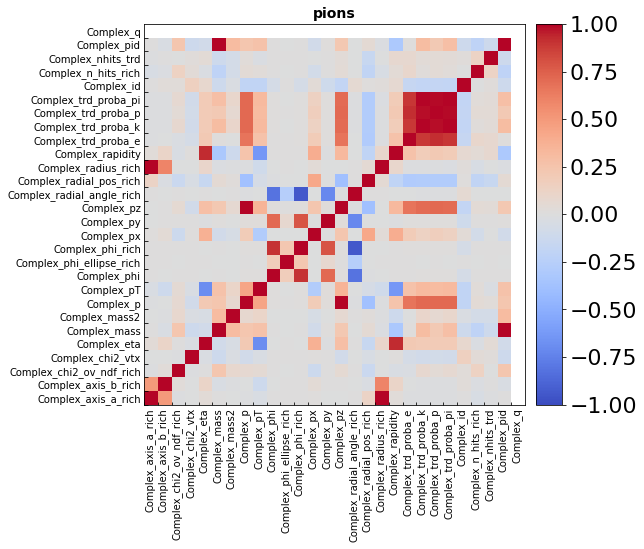

In [10]:
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
plot_utils.plot_corr([protons, kaons, pions], vars_to_draw, leg_labels)

plt.show()

In [11]:
del protons, kaons, pions
gc.collect()
features_for_train = ['Complex_mass2', 'Complex_p', 'Complex_pT', 'Complex_eta']

In [12]:
model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, features_for_train)

In [13]:
hyper_pars_ranges = {"n_estimators": (200, 1000), "max_depth": (2, 4), "learning_rate": (0.01, 0.1)}
study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring="roc_auc_ovo", timeout=120,
                                 n_jobs=2, n_trials=5, direction="maximize")

[I 2023-03-06 18:23:16,689] A new study created in memory with name: no-name-97bf6a04-778c-400e-9d97-379ec9396e57
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-03-06 18:31:55,531] Trial 1 finished with value: 0.9836991004998072 and parameters: {'n_estimators': 765, 'max_depth': 3, 'learning_rate': 0.02902905367448421}. Best is trial 1 with value: 0.9836991004998072.
[I 2023-03-06 18:35:38,753] Trial 0 finished with value: 0.9836141077687136 and parameters: {'n_estimators': 976, 'max_depth': 4, 'learning_rate': 0.08619585492497901}. Best is trial 1 with value: 0.9836991004998072.


Number of finished trials: 2
Best trial:
Value: 0.9836991004998072
Params: 
    n_estimators: 765
    max_depth: 3
    learning_rate: 0.02902905367448421


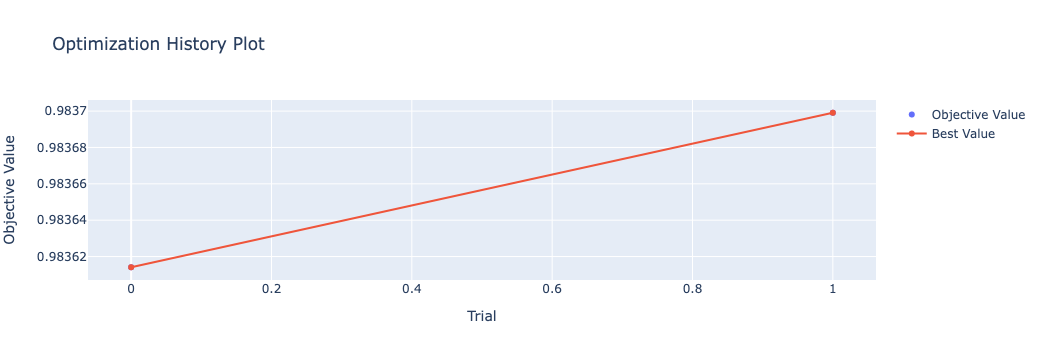

In [14]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
plot_optimization_history(study)

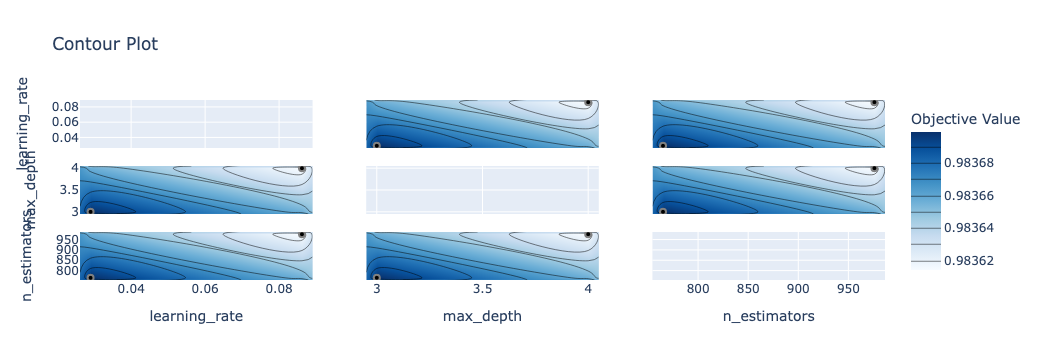

In [15]:
plot_contour(study)

In [16]:
model_hdl.train_test_model(train_test_data, multi_class_opt="ovo")

Training xgboost model for classification
Number of detected classes: 3
Training the model: ...
Training the model: Done!
Testing the model: ...
ROC_AUC_score: 0.983553
Testing the model: Done!


In [17]:
y_pred_train = model_hdl.predict(train_test_data[0], False)
y_pred_test = model_hdl.predict(train_test_data[2], False)

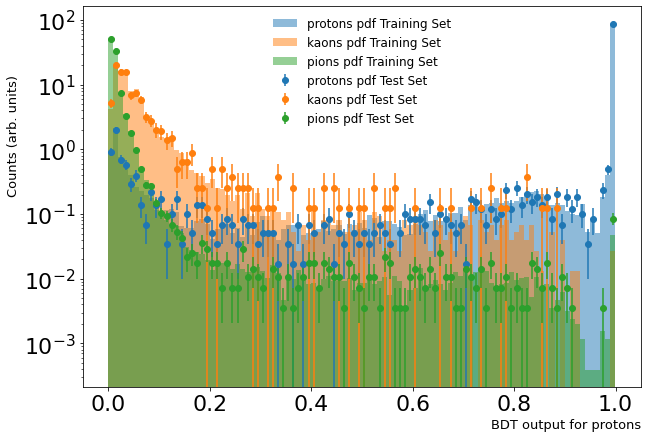

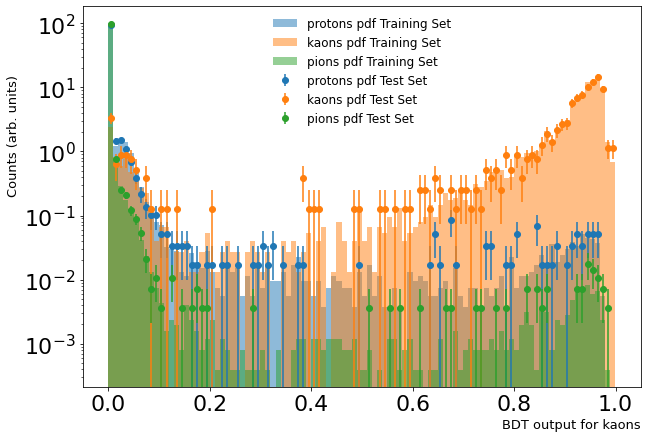

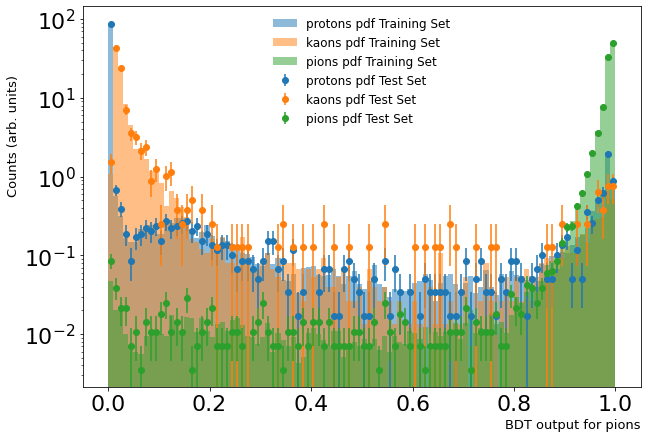

In [18]:
plt.rcParams["figure.figsize"] = (10, 7)

ml_out_fig = plot_utils.plot_output_train_test(model_hdl, train_test_data, 100, 
                                               False, leg_labels, True, density=True)

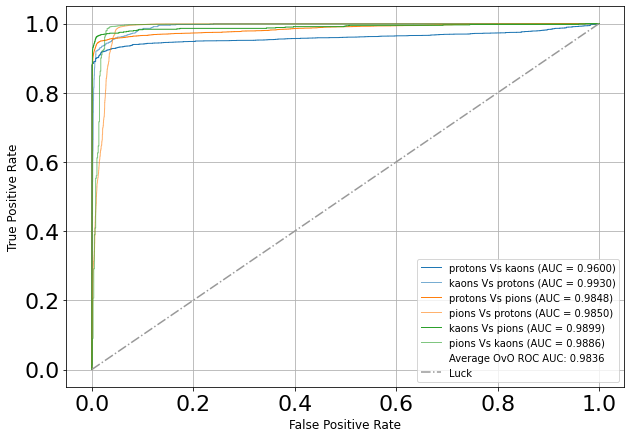

In [19]:
roc_train_test_fig = plot_utils.plot_roc(train_test_data[3], y_pred_test, None, leg_labels, multi_class_opt="ovo")

In [20]:
testParticles = loadFile(fileNameTest)
testParticles.apply_model_handler(model_hdl, False)

In [21]:
testParticles.get_data_frame().head(10)

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1              5.839708             5.313001                  0.520030   
2              4.722127             4.181828                  0.456715   
7              5.390869             5.038420                  0.541778   
10             5.481655             5.204248                  0.389541   
12             5.282866             4.732232                  0.292067   
13             5.424021             5.076087                  0.629069   
14             5.701984             5.217088                  1.302346   
24             4.982846             4.780129                  0.616440   
26             5.635751             5.426417                  0.471135   
27             5.155520             4.999420                  0.243999   

    Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  Complex_p  \
1           3.254713     1.615815      0.139570       0.013776   1.040541   
2           6.383036     2.477988      0.139570       0.009510   0.877198   
7           0.983985     3.756489      0.139570       0.022315   0.888626   
10         16.352009     2.234060      0.000511      -0.000921   0.460188   
12          2.799417     1.127367      0.000511      -0.004686   0.981654   
13          0.576499     2.461298      0.493677       0.238667   1.332283   
14          1.042173     1.710407      0.139570       0.000192   1.535469   
24          1.342454     1.694063      0.938272       0.979229   1.594529   
26          0.701677     3.479935      0.139570       0.022383   1.635057   
27         11.140937     2.491263      0.000511       0.000592   0.579213   

    Complex_pT  Complex_phi  ...  Complex_trd_proba_p  Complex_trd_proba_pi  \
1     0.397858     1.967648  ...             0.173623              0.396563   
2     0.146186     1.035680  ...             0.285724              0.340778   
7     0.041505    -1.281722  ...             0.069788              0.404519   
10    0.097448    -2.465459  ...            -1.500000             -1.500000   
12    0.575513    -2.893483  ...             0.497897              0.230621   
13    0.225708    -0.622119  ...             0.363714              0.319583   
14    0.537629    -3.062980  ...             0.212057              0.329243   
24    0.566912    -2.059282  ...             0.365606              0.331896   
26    0.100655    -1.021812  ...             0.329330              0.342157   
27    0.095271     0.349122  ...            -1.500000             -1.500000   

    Complex_id  Complex_n_hits_rich  Complex_nhits_trd  Complex_pid  \
1          1.0                 29.0                4.0        211.0   
2          2.0                 27.0                2.0        211.0   
7          7.0                 26.0                4.0        211.0   
10        10.0                 35.0                4.0        -11.0   
12        12.0                 27.0                4.0        -11.0   
13         0.0                 18.0                3.0        321.0   
14         1.0                 22.0                4.0        211.0   
24        11.0                 32.0                3.0       2212.0   
26        13.0                 25.0                3.0        211.0   
27        14.0                 18.0                2.0        -11.0   

    Complex_q  model_output_0  model_output_1  model_output_2  
1         1.0        0.018078        0.000498        0.981424  
2         1.0        0.017371        0.001393        0.981236  
7         1.0        0.006864        0.000703        0.992433  
10        1.0        0.002073        0.001484        0.996443  
12        1.0        0.007502        0.000446        0.992051  
13        1.0        0.034102        0.945174        0.020725  
14        1.0        0.005068        0.000377        0.994555  
24        1.0        0.995856        0.000147        0.003996  
26        1.0        0.011010        0.000489        0.988501  
27        1.0        0.001111        0.000410    

In [22]:
def xgb_preds(df, probaProton, probaKaon, probaPion):
    #getting max field
    df['xgb_preds']=df[["model_output_0", "model_output_1", "model_output_2"]].idxmax(axis = 1)
    #setting to bckgr if smaller than probability threshold
    proton = (df['xgb_preds'] == 0) & (df["model_output_0"] > probaProton )
    pion   = (df['xgb_preds'] == 1) & (df["model_output_1"] > probaKaon )
    kaon   = (df['xgb_preds'] == 2) & (df["model_output_2"] > probaPion )
    df.loc[( proton | pion | kaon ), 'xgb_preds'] = 3
    df['xgb_preds'] = df['xgb_preds'].map(lambda x: x.lstrip('model_output_')).astype(float)
    return df

from collections import defaultdict
def remap_names(df):
    if antiParticles == False:
        return df.Complex_pid.map(defaultdict(lambda: 3., {Pid.PROTON.value : 0., Pid.POS_KAON.value : 1.,  Pid.POS_PION.value : 2, Pid.POSITRON.value : 2., Pid.POS_MUON.value : 2.}),na_action='ignore').astype(float)
    elif antiParticles == True:
        return df.Complex_pid.map(defaultdict(lambda: 3., {Pid.ANTI_PROTON.value : 0., Pid.NEG_KAON.value : 1.,  Pid.NEG_PION.value : 2., Pid.ELECTRON.value : 2., Pid.NEG_MUON.value : 2.}),na_action='ignore').astype(float)


In [23]:
testParticles = xgb_preds(testParticles.get_data_frame(), .9, .9, .9)
testParticles["Complex_pid"] = remap_names(testParticles)

In [24]:
testParticles.head(10)

Complex_axis_a_rich  Complex_axis_b_rich  Complex_chi2_ov_ndf_rich  \
1              5.839708             5.313001                  0.520030   
2              4.722127             4.181828                  0.456715   
7              5.390869             5.038420                  0.541778   
10             5.481655             5.204248                  0.389541   
12             5.282866             4.732232                  0.292067   
13             5.424021             5.076087                  0.629069   
14             5.701984             5.217088                  1.302346   
24             4.982846             4.780129                  0.616440   
26             5.635751             5.426417                  0.471135   
27             5.155520             4.999420                  0.243999   

    Complex_chi2_vtx  Complex_eta  Complex_mass  Complex_mass2  Complex_p  \
1           3.254713     1.615815      0.139570       0.013776   1.040541   
2           6.383036     2.477988      0.139570       0.009510   0.877198   
7           0.983985     3.756489      0.139570       0.022315   0.888626   
10         16.352009     2.234060      0.000511      -0.000921   0.460188   
12          2.799417     1.127367      0.000511      -0.004686   0.981654   
13          0.576499     2.461298      0.493677       0.238667   1.332283   
14          1.042173     1.710407      0.139570       0.000192   1.535469   
24          1.342454     1.694063      0.938272       0.979229   1.594529   
26          0.701677     3.479935      0.139570       0.022383   1.635057   
27         11.140937     2.491263      0.000511       0.000592   0.579213   

    Complex_pT  Complex_phi  ...  Complex_trd_proba_pi  Complex_id  \
1     0.397858     1.967648  ...              0.396563         1.0   
2     0.146186     1.035680  ...              0.340778         2.0   
7     0.041505    -1.281722  ...              0.404519         7.0   
10    0.097448    -2.465459  ...             -1.500000        10.0   
12    0.575513    -2.893483  ...              0.230621        12.0   
13    0.225708    -0.622119  ...              0.319583         0.0   
14    0.537629    -3.062980  ...              0.329243         1.0   
24    0.566912    -2.059282  ...              0.331896        11.0   
26    0.100655    -1.021812  ...              0.342157        13.0   
27    0.095271     0.349122  ...             -1.500000        14.0   

    Complex_n_hits_rich  Complex_nhits_trd  Complex_pid  Complex_q  \
1                  29.0                4.0          2.0        1.0   
2                  27.0                2.0          2.0        1.0   
7                  26.0                4.0          2.0        1.0   
10                 35.0                4.0          2.0        1.0   
12                 27.0                4.0          2.0        1.0   
13                 18.0                3.0          1.0        1.0   
14                 22.0                4.0          2.0        1.0   
24                 32.0                3.0          0.0        1.0   
26                 25.0                3.0          2.0        1.0   
27                 18.0                2.0          2.0        1.0   

    model_output_0  model_output_1  model_output_2  xgb_preds  
1         0.018078        0.000498        0.981424        2.0  
2         0.017371        0.001393        0.981236        2.0  
7         0.006864        0.000703        0.992433        2.0  
10        0.002073        0.001484        0.996443        2.0  
12        0.007502        0.000446        0.992051        2.0  
13        0.034102        0.945174        0.020725        1.0  
14        0.005068        0.000377        0.994555        2.0  
24        0.995856        0.000147        0.003996        0.0  
26        0.011010        0.000489        0.988501        2.0  
27        0.001111        0.000410        0.998479        2.0  

[10 rows x 32 columns]

In [25]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[ 54577    447   4341      0]
 [   216   7709    372      0]
 [  1280    272 279535      0]
 [  5370    950  63388      0]]


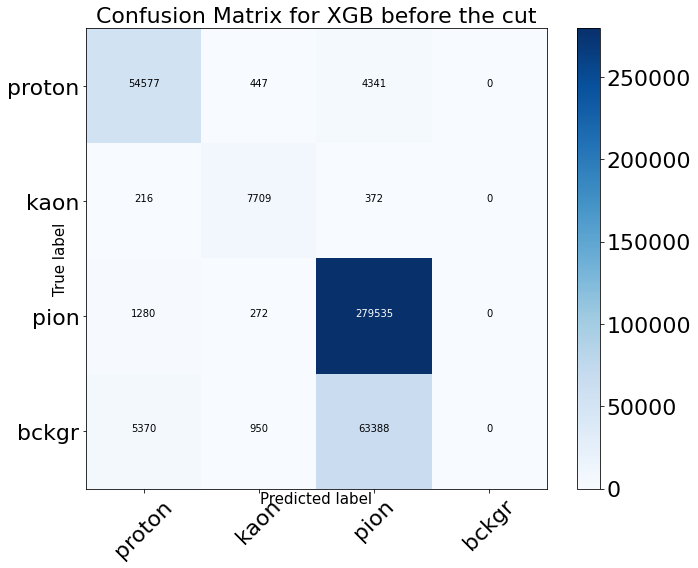

In [26]:
classes = ['proton', 'kaon', 'pion', 'bckgr']

np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(testParticles['Complex_pid'], testParticles['xgb_preds'])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=False)
# fig.savefig(directory+'img/' + title + '.pdf')
plt.show()

Normalized confusion matrix
[[9.19e-01 7.53e-03 7.31e-02 0.00e+00]
 [2.60e-02 9.29e-01 4.48e-02 0.00e+00]
 [4.55e-03 9.68e-04 9.94e-01 0.00e+00]
 [7.70e-02 1.36e-02 9.09e-01 0.00e+00]]


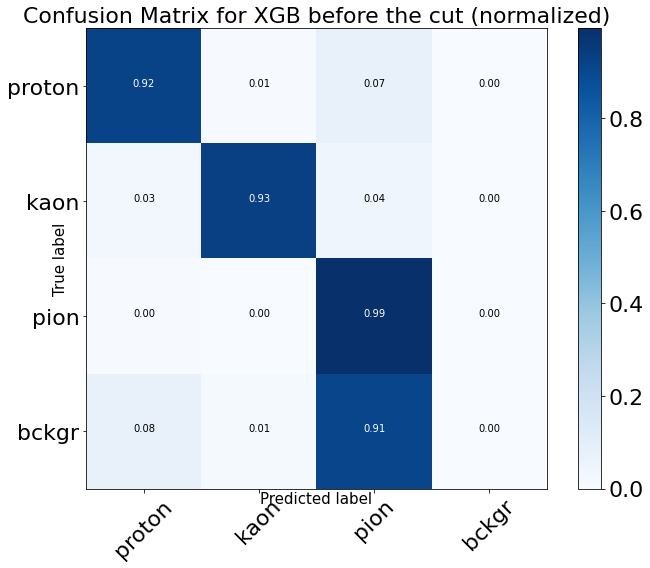

In [27]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(testParticles['Complex_pid'], testParticles['xgb_preds'])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut (normalized)'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=True)
# fig.savefig(directory+'img/' + title + '.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')
plt.show()

In [28]:
def plot_mass2(pid, name, range1, setLog=False):

    # fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
    #                            'height_ratios': [8,4]})
    fig, axs = plt.subplots(figsize=(15,10))

    
    xgb_mass = testParticles[testParticles['xgb_preds']==pid]['Complex_mass2']
    sim_mass = testParticles[testParticles['Complex_pid']==pid]['Complex_mass2']
    
    ns, bins, patches=axs.hist(xgb_mass ,bins = 300,  facecolor='red',alpha = 0.3, range=range1)
    ns1, bins1, patches1=axs.hist( sim_mass ,bins = 300,facecolor='blue',alpha = 0.3, range=range1)
    #plt.xlabel("Mass in GeV", fontsize = 15)
    axs.set_ylabel("counts", fontsize = 15)
    #axs[0].grid()
    axs.legend(('XGBoost selected ' + name,'all simulated ' + name), fontsize = 15, loc='upper right')

    #plt.rcParams["legend.loc"] = 'upper right'
    title = name +  " mass-squared histogram"
    yName = r'Counts'
    xName = r'$m^2$ $(GeV/c^2)^2$'
    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    axs.set_title(title, fontsize = 20)
    axs.grid()
    axs.tick_params(axis='both', which='major', labelsize=18)
    #fig.savefig("whole_sample_invmass_with_ML.png")
   

    # hist1, bin_edges1 = np.histogram(xgb_mass, bins=200, range=range1)
#     hist2, bin_edges2 = np.histogram(sim_mass, bins=200, range=range1)
        # axs.set_yscale('log')
    # fig.tight_layout()
    # plt.savefig(directory+'img/ml/ ' + name + '.pdf')
    plt.show()

    # fig.savefig(directory+'img/' + title + '.pdf')
  

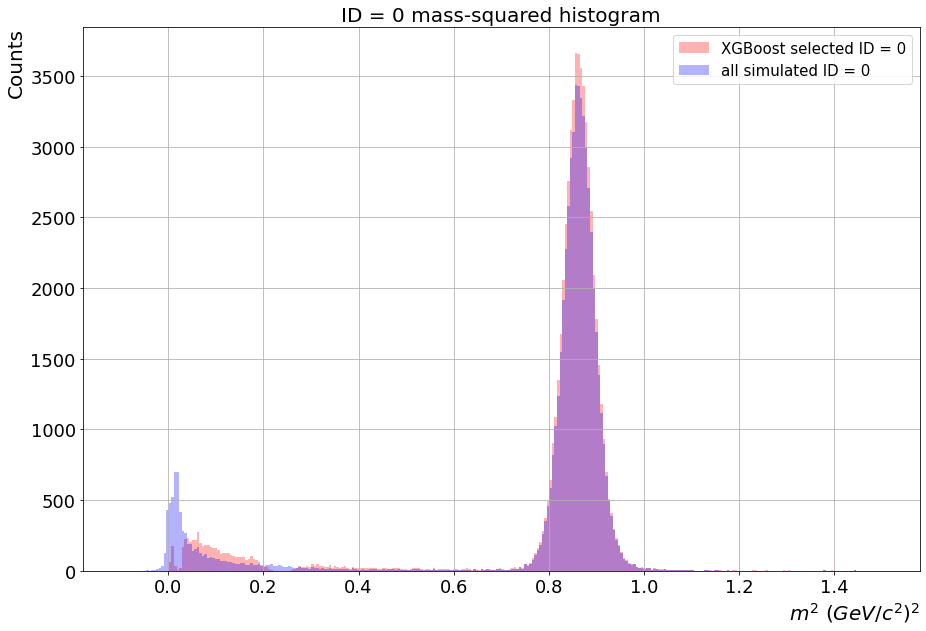

In [29]:
plot_mass2(0, 'ID = 0', (-.1, 1.5))

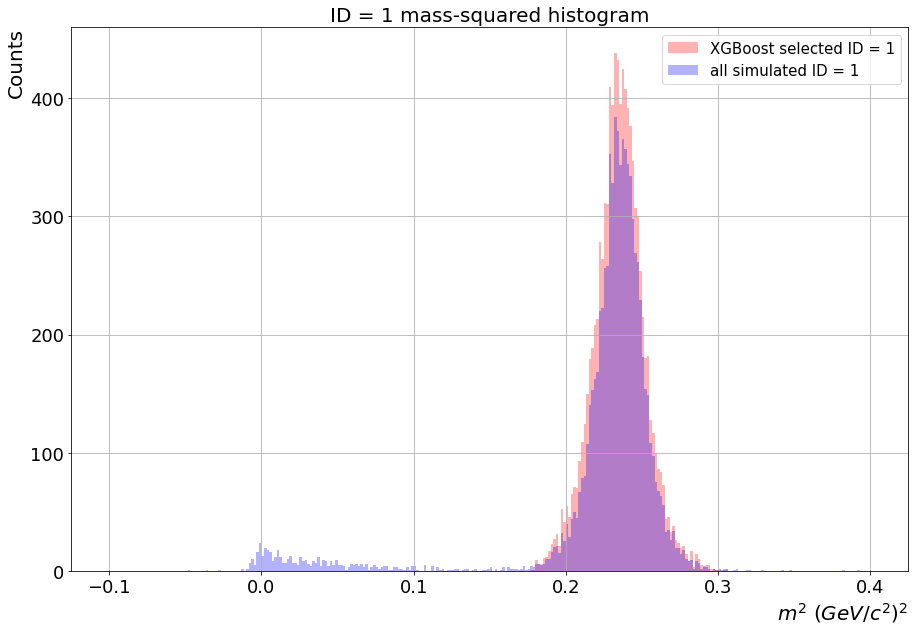

In [30]:
plot_mass2(1, 'ID = 1', (-.1, .4))

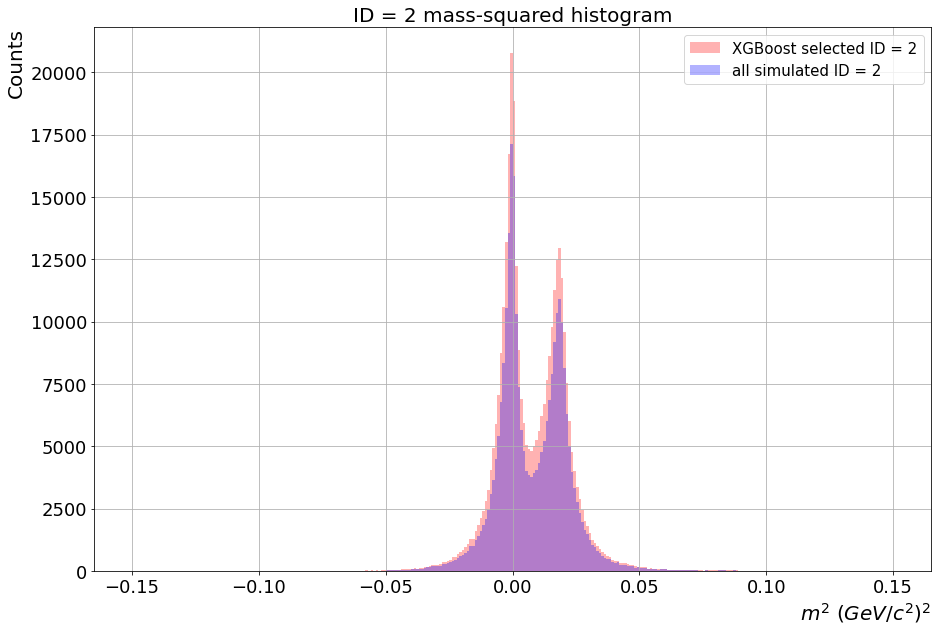

In [31]:
plot_mass2(2, 'ID = 2', (-.15, .15))

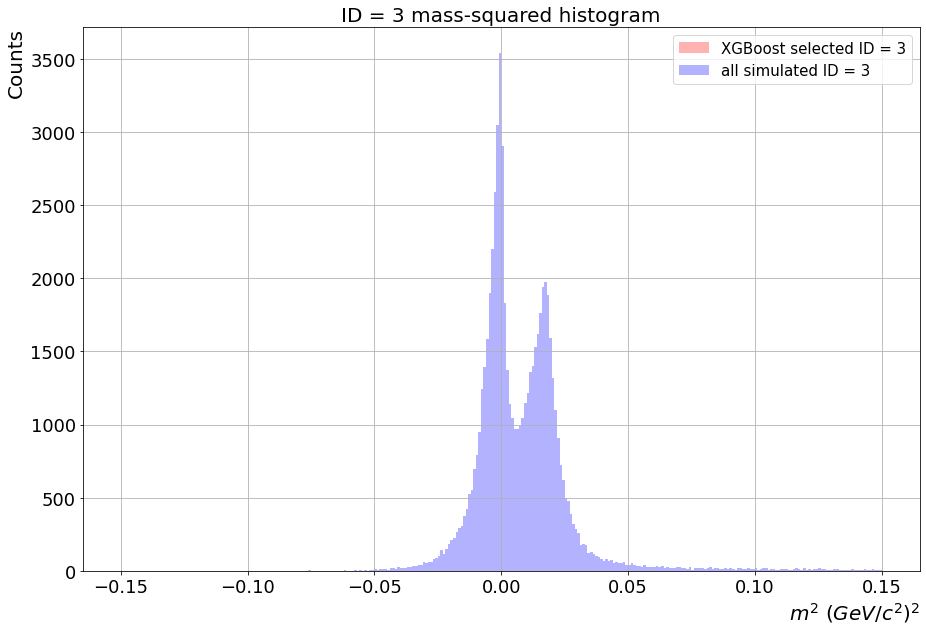

In [32]:
plot_mass2(3, 'ID = 3', (-.15, .15))

In [33]:
import matplotlib as mpl
def xgb_tof(pid):

    qp = testParticles[testParticles['xgb_preds']==pid]['Complex_q']*testParticles[testParticles['xgb_preds']==pid]['Complex_p']
    var_xaxis = qp
    mass2 = testParticles[testParticles['xgb_preds']==pid]['Complex_mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for XGB-selected particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    # plt.savefig(directory+'img/ml/xgb ' + str(pid) + '.pdf')
    plt.show()
def sim_tof(pid):

    qp = testParticles[testParticles['Complex_pid']==pid]['Complex_q']*testParticles[testParticles['Complex_pid']==pid]['Complex_p']
    var_xaxis = qp
    mass2 = testParticles[testParticles['Complex_pid']==pid]['Complex_mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    # plt.savefig(directory+'img/ml/sim ' + str(pid) + '.pdf')
    plt.show()
    

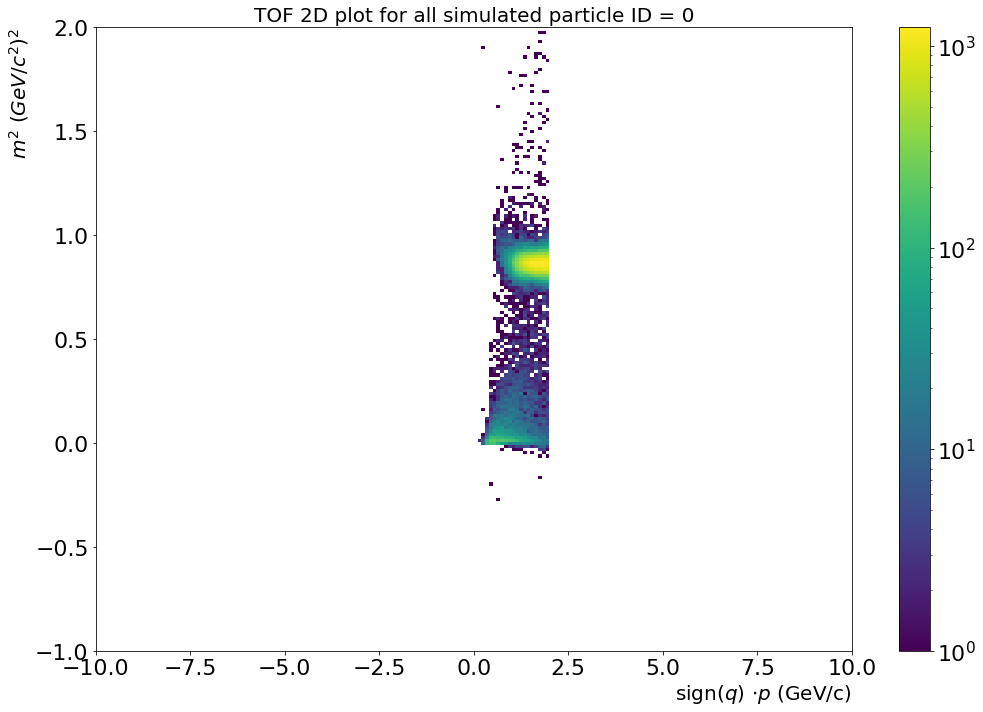

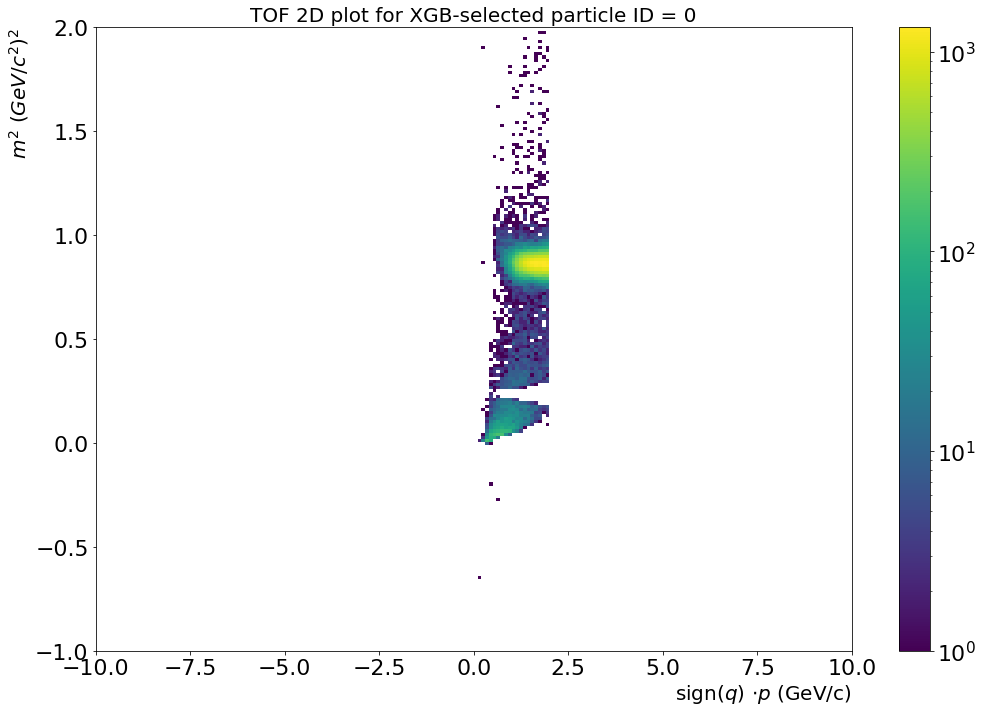

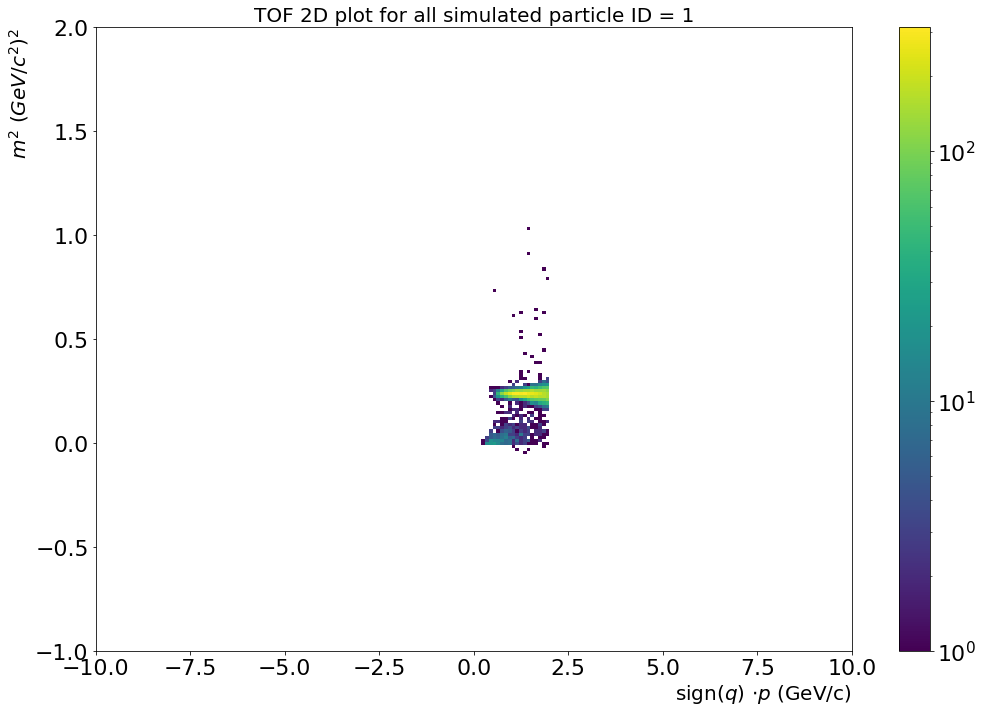

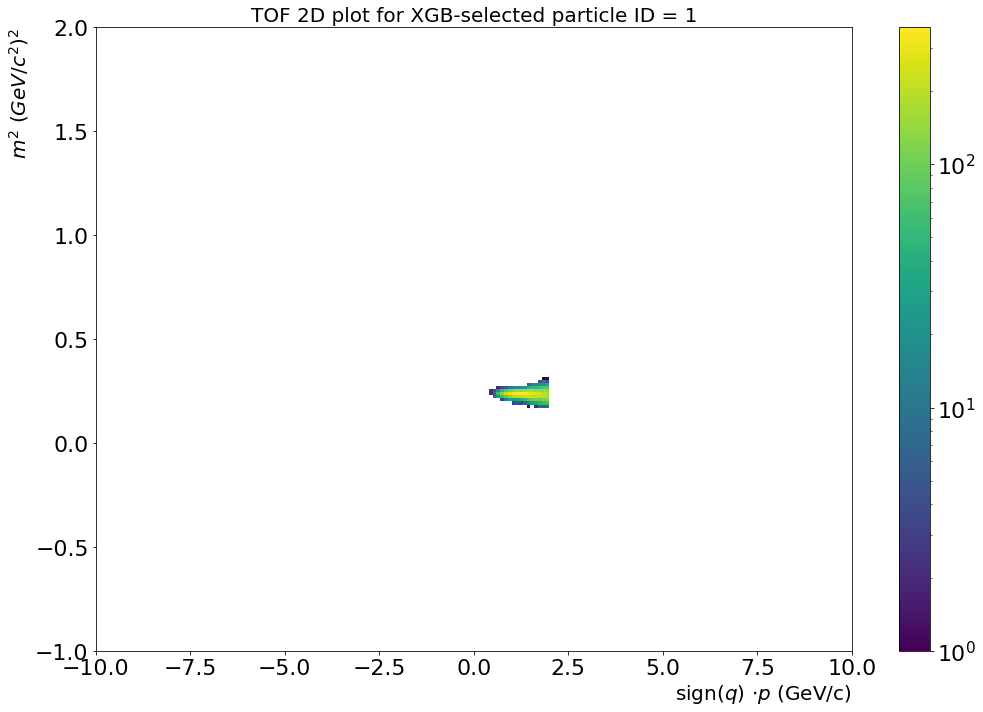

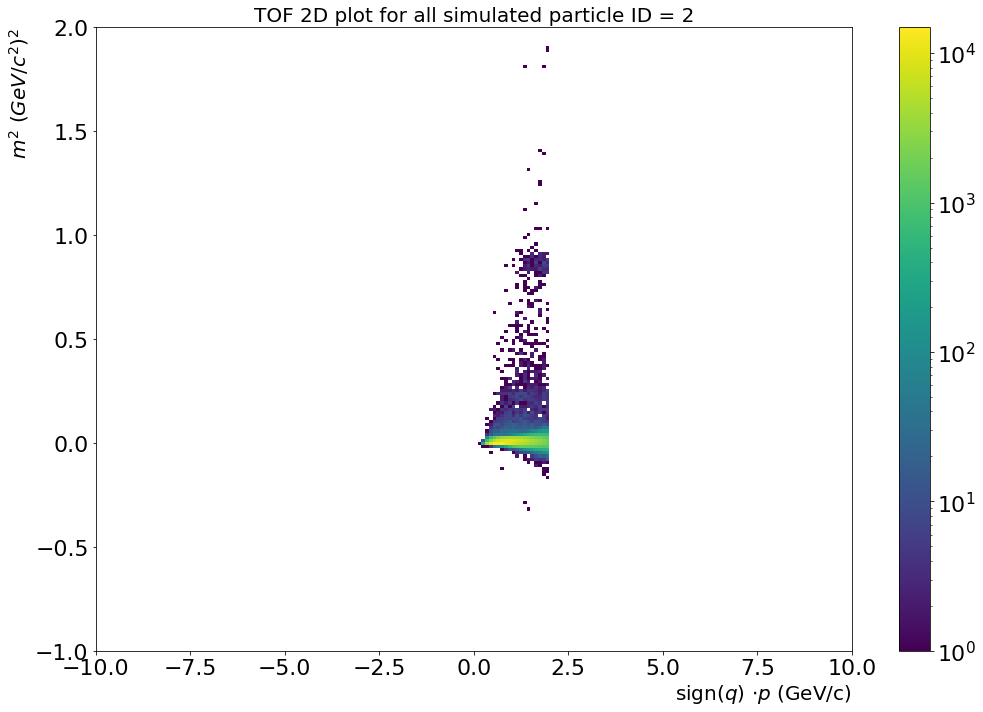

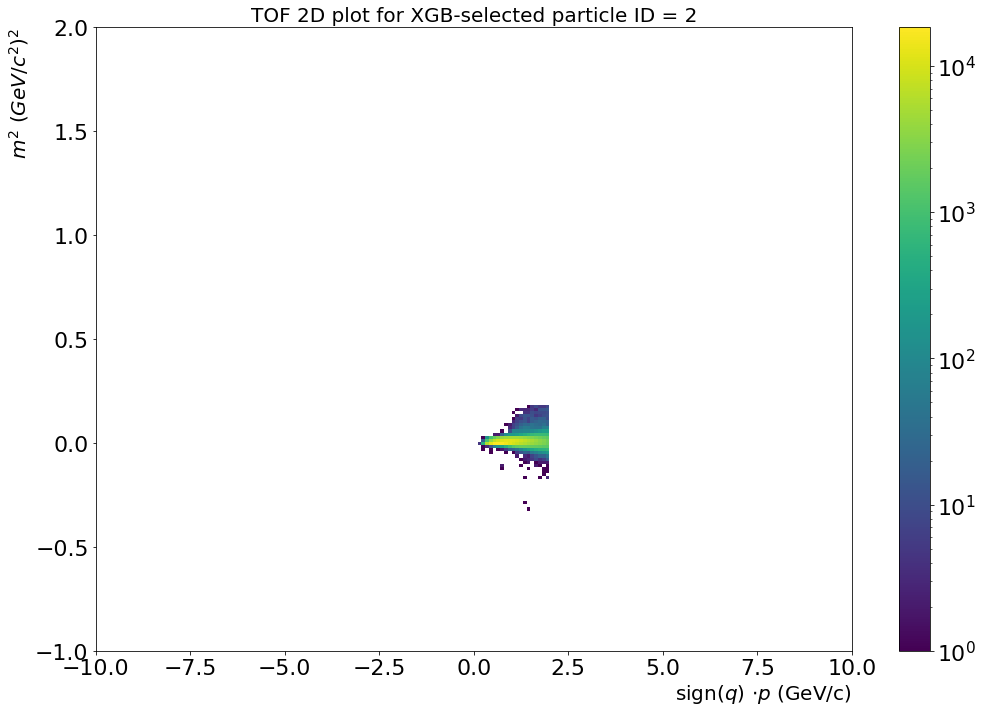

In [34]:
for i in range(3):
    sim_tof(i)
    xgb_tof(i)